In [40]:
import numpy as np
import pandas as pd
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pickle

The purpose of this notebook is to apply create features from free-form text columns for use in a ML classifier algorithm to detect fake news.

# Table of Contents<a id='ToC'></a>

- High Level Description [1](#Description)

- Word level analysis [2](#WordAnalysis)

- Feature Engineering [3](#Features)

- Summary statistics [4](#Summary)

- Word count statistics [5](#TfIdf)

- Sentence structure statistics [6](#PoS)

- Named Entity Statistics [7](#NER)

- Text sentiment Statistics [8](#Vader)

- Topic Modelling statistics [9](#LDA)

In [2]:
df = pd.read_csv('fake_news_classifier.csv')

# High Level Description [Return](#ToC) <a id = 'Description'></a>

In [3]:
df.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


Any news article without a body of text is dropped from the analysis. News articles with no author or titles are filled in. The id columns is redundant.

In [5]:
def clean_dataframe(df):
    df.drop('id', axis = 1, inplace = True)
    df.dropna(subset = ['text'], inplace = True)
    df['author'].fillna('author unknown', inplace = True)
    df['title'].fillna('no title', inplace = True)
    df.reset_index(drop = True, inplace = True)
    return

In [6]:
clean_dataframe(df)

In [7]:
# Look at label distribution
df['label'].value_counts()

0    10387
1    10374
Name: label, dtype: int64

The datasets outcome is very balanced, with approximately the same number of fake news articles (denoted 1) compared to real news articles (denoted 0)

In [8]:
# Look at label distribution
print(f'Number of distinct authors: {len(df["author"].value_counts())}')
print('')
print(f'Most profilic authors')
print(df['author'].value_counts().head(10))

Number of distinct authors: 4202

Most profilic authors
author unknown         1918
Pam Key                 243
admin                   193
Jerome Hudson           166
Charlie Spiering        141
John Hayward            140
Katherine Rodriguez     124
Warner Todd Huston      122
Ian Hanchett            119
Breitbart News          118
Name: author, dtype: int64


There are over 4000 distinct authors in this dataset, with one single author (Pam Key) accounting for over 1%. In the author list there are some interesting names, such as admin or Breibart News.

# Word level analysis [Return](#ToC) <a id = 'WordAnalysis'></a>

First we examine the corpus of the news articles bodies and titles to determine the number of unique tokens contained within the dataset.

In [9]:
def calculate_corpus(df, column):
    results = set()
    _ = df[column].dropna().str.lower().str.split().apply(results.update)
    return results

In [10]:
text_corpus = calculate_corpus(df, 'text')
title_corpus = calculate_corpus(df, 'title')

In [11]:
print(f'There are {len(title_corpus)} unique words across all titles')
print(f'There are {len(text_corpus)} unique words across all news body')

There are 36114 unique words across all titles
There are 437349 unique words across all news body


# Feature Engineering [Return](#ToC) <a id = 'Features'></a>

The following sections derive features from the fields. These are split into different themes of work, where different aspects of the data are considered in turn.

# Text Summary Statistics [Return](#ToC) <a id = 'Summary'></a>

First, we examine summary statistics of the news articles such as the number of characters, the number of words, the number of sentences etc. This will help us understand their basic structure. Some pre-processing is applied to remove unwanted characters from the articles first before they are processed. 

In [91]:
def histogram_label(df, col):
    for cat in df['label'].unique():
        sns.distplot(df[df['label'] == cat][col].values, hist = False, label = cat)
        plt.xlabel(col)
        plt.ylabel('pdf')

In [148]:
def regex_clean_1(x):
    if pd.isna(x):
        return np.nan
    else:
        return re.sub('[^a-zA-Z0-9.]', ' ', x)
    
    
def regex_clean_2(x):
    if pd.isna(x):
        return np.nan
    else:
        return re.sub('[^a-zA-Z.]', ' ', x)

In [149]:
def high_level_text_summary(df, col):
    df['_'.join([col, 'clean'])] = df[col].apply(regex_clean_1)
    df['_'.join([col, 'clean'])] = df['_'.join([col, 'clean'])].str.lower()
    df['_'.join([col, 'tot_chars'])] = df['_'.join([col, 'clean'])].str.len()
    df['_'.join([col, 'tot_words'])] = df['_'.join([col, 'clean'])].str.split().str.len()
    df['_'.join([col, 'tot_sentences'])] = df['_'.join([col, 'clean'])].str.split('.').str.len()
    df['_'.join([col, 'tot_line_breaks'])] = df['_'.join([col, 'clean'])].str.split('\n').str.len()
    df['_'.join([col, 'clean'])] = df['_'.join([col, 'clean'])].apply(regex_clean_2)
    return df                                          

In [150]:
df = high_level_text_summary(df, 'text')
df = high_level_text_summary(df, 'title')

In [151]:
def plot_multiple_kdes(df, columns, ncol, nrow):
    
    fig, axes = plt.subplots(ncols=ncol, nrows=nrow)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    for i, ax in zip(columns, axes.flat):
        for cat in df['label'].unique():
            sns.distplot(df[df['label'] == cat][i].values, hist = False, label = cat, ax = ax)
        ax.set_yticklabels([])
        ax.set_xlabel(i)
    plt.tight_layout()
    plt.show()

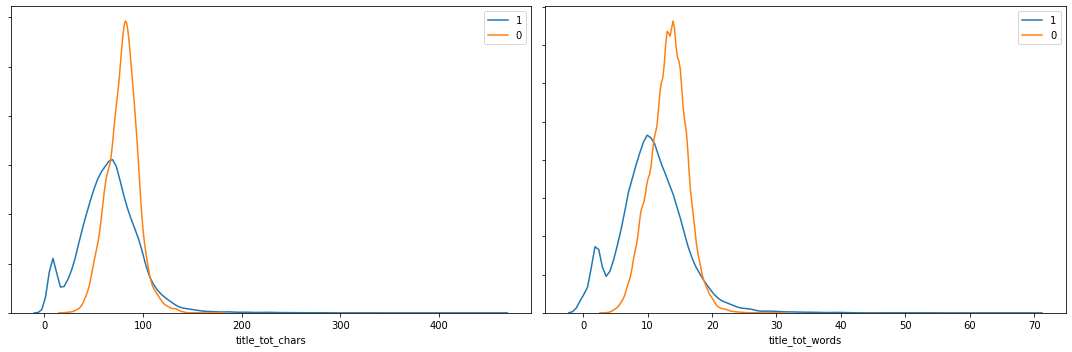

In [152]:
plot_multiple_kdes(df, ['title_tot_chars', 'title_tot_words'], 2, 1)

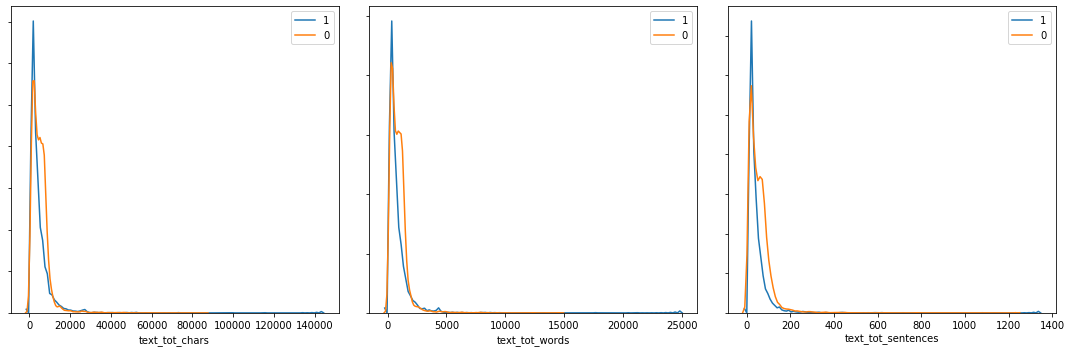

In [153]:
plot_multiple_kdes(df, ['text_tot_chars', 'text_tot_words', 'text_tot_sentences'], 3, 1)

# Word Frequency Statistics [Return](#ToC) <a id = 'TfIdf'></a>
The next analysis is to examine the occurences of particular words within the articles main body of text. The hypothesis is that there will be key words or phrases that the different classes will use. Term frequency Inverse document frequency (TfIdf) is chosen of the bag of Words (BoW) approach so that unique identifying words can be identified, and not just common words. Unigrams and bigrams are calculated and the max features is set to 1000, but these are free parameters that can be tuned.

In [154]:
tf = TfidfVectorizer(max_features = 1000, ngram_range = (1, 2), stop_words = 'english')
tf.fit(df['text_clean'].dropna())
res = tf.transform(df['text_clean'].dropna())
tfidf_df = pd.DataFrame(res.toarray(), columns = tf.get_feature_names())

In [278]:
def plot_top_words_by_label(tf, label):
    tf['label'] = label
    fig, axes = plt.subplots(ncols = 2, nrows = 1)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    for label_type, ax in enumerate(axes.flat):
        tf_sum = tf[tf['label'] == label_type].sum(axis = 0).sort_values(ascending = False).drop('label', axis = 0).head(20).reset_index()
        tf_sum.rename(columns = {'index': 'Word', 0: 'Frequency'}, inplace = True)
        sns.barplot(x = 'Word', y = 'Frequency', data = tf_sum, ax = ax)
        ax.tick_params(labelrotation=90)
    return tf

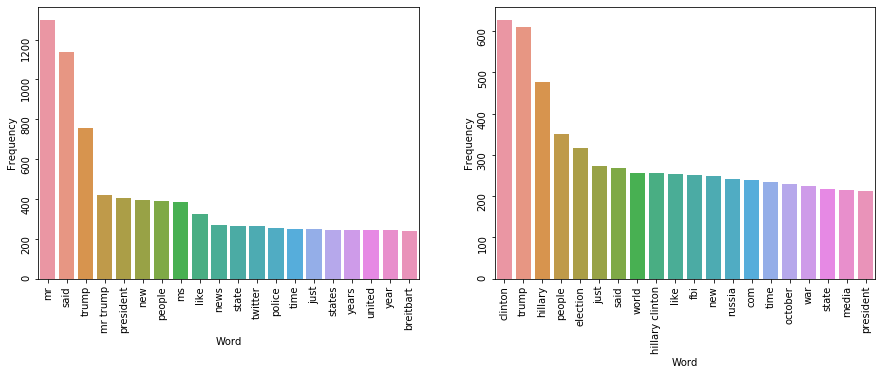

In [279]:
test = plot_top_words_by_label(tfidf_df, df['label'])

# Text structure Statistics [Return](#ToC) <a id = 'PoS'></a>
The next analysis is to examine the linguistic structure of the titles and main bodies of the news articles. The hypothesis is that different classes of news articles will use different parts of speech within their text. To accomplish the Part of Speech (PoS) tagger from SpaCy is used, and the different categories of speech are counted for their occurence in each news article, both title and story.

In [464]:
# Extract the pos statistics for text
rerun = False
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])
nlp.pipe_names
if rerun:
    n_batch = 10
    pos_summary = []
    # Where texts is an iterator over your documents (unicode)
    for docs in nlp.pipe(df['text_clean'], batch_size=n_batch, n_threads=3):
        pos = [docs[i].pos_ for i in np.arange(len(docs))]
        pos_summary.append(dict(Counter(pos)))
    filename = './param_store/PoS_data_text'
    outfile = open(filename,'wb')
    pickle.dump(pos_summary, outfile)
    outfile.close()
else:
    filename = './param_store/PoS_data_text'
    outfile = open(filename,'rb')
    pos_summary = pickle.load(outfile)
    outfile.close()

In [465]:
df_orig = pd.DataFrame([list(pos_summary[0].values())], columns = list(pos_summary[0].keys()))
for idx in np.arange(1, len(pos_summary)):
    df_join = pd.DataFrame([list(pos_summary[idx].values())], columns = list(pos_summary[idx].keys()))
    df_orig = pd.concat([df_orig, df_join], ignore_index = True)
df_orig.fillna(0, inplace = True)
df_pos_norm_text = df_orig.div(df_orig.sum(axis=1), axis=0)

In [466]:
df_pos_norm_text = df_pos_norm_text.add_prefix('text_')

In [457]:
# Extract the pos statistics for title
rerun = False
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])
nlp.pipe_names
if rerun:
    n_batch = 10
    pos_summary = []
    # Where texts is an iterator over your documents (unicode)
    for docs in nlp.pipe(df['title_clean'], batch_size=n_batch, n_threads=3):
        pos = [docs[i].pos_ for i in np.arange(len(docs))]
        pos_summary.append(dict(Counter(pos)))
    filename = './param_store/PoS_data_title'
    outfile = open(filename,'wb')
    pickle.dump(pos_summary, outfile)
    outfile.close()
else:
    filename = './param_store/PoS_data_title'
    outfile = open(filename,'rb')
    pos_sumary = pickle.load(outfile)
    outfile.close()

In [458]:
df_orig = pd.DataFrame([list(pos_summary[0].values())], columns = list(pos_summary[0].keys()))
for idx in np.arange(1, len(pos_summary)):
    df_join = pd.DataFrame([list(pos_summary[idx].values())], columns = list(pos_summary[idx].keys()))
    df_orig = pd.concat([df_orig, df_join], ignore_index = True)
df_orig.fillna(0, inplace = True)
df_pos_norm_title = df_orig.div(df_orig.sum(axis=1), axis=0)

In [460]:
df_pos_norm_title = df_pos_norm_title.add_prefix('title_')

In [461]:
def pos_plots(df, label, nrow, ncol):
    columns = df.columns
    df['label'] = label
    fig, axes = plt.subplots(ncols=ncol, nrows=nrow)
    fig.set_figheight(30)
    fig.set_figwidth(15)
    for i, ax in zip(columns, axes.flat):
        for cat in df['label'].unique():
            sns.distplot(df[df['label'] == cat][i].values, hist = True, kde = False, label = cat, ax = ax)
        ax.set_xlabel(i)
    plt.tight_layout()
    df.drop('label', axis = 1, inplace = True)

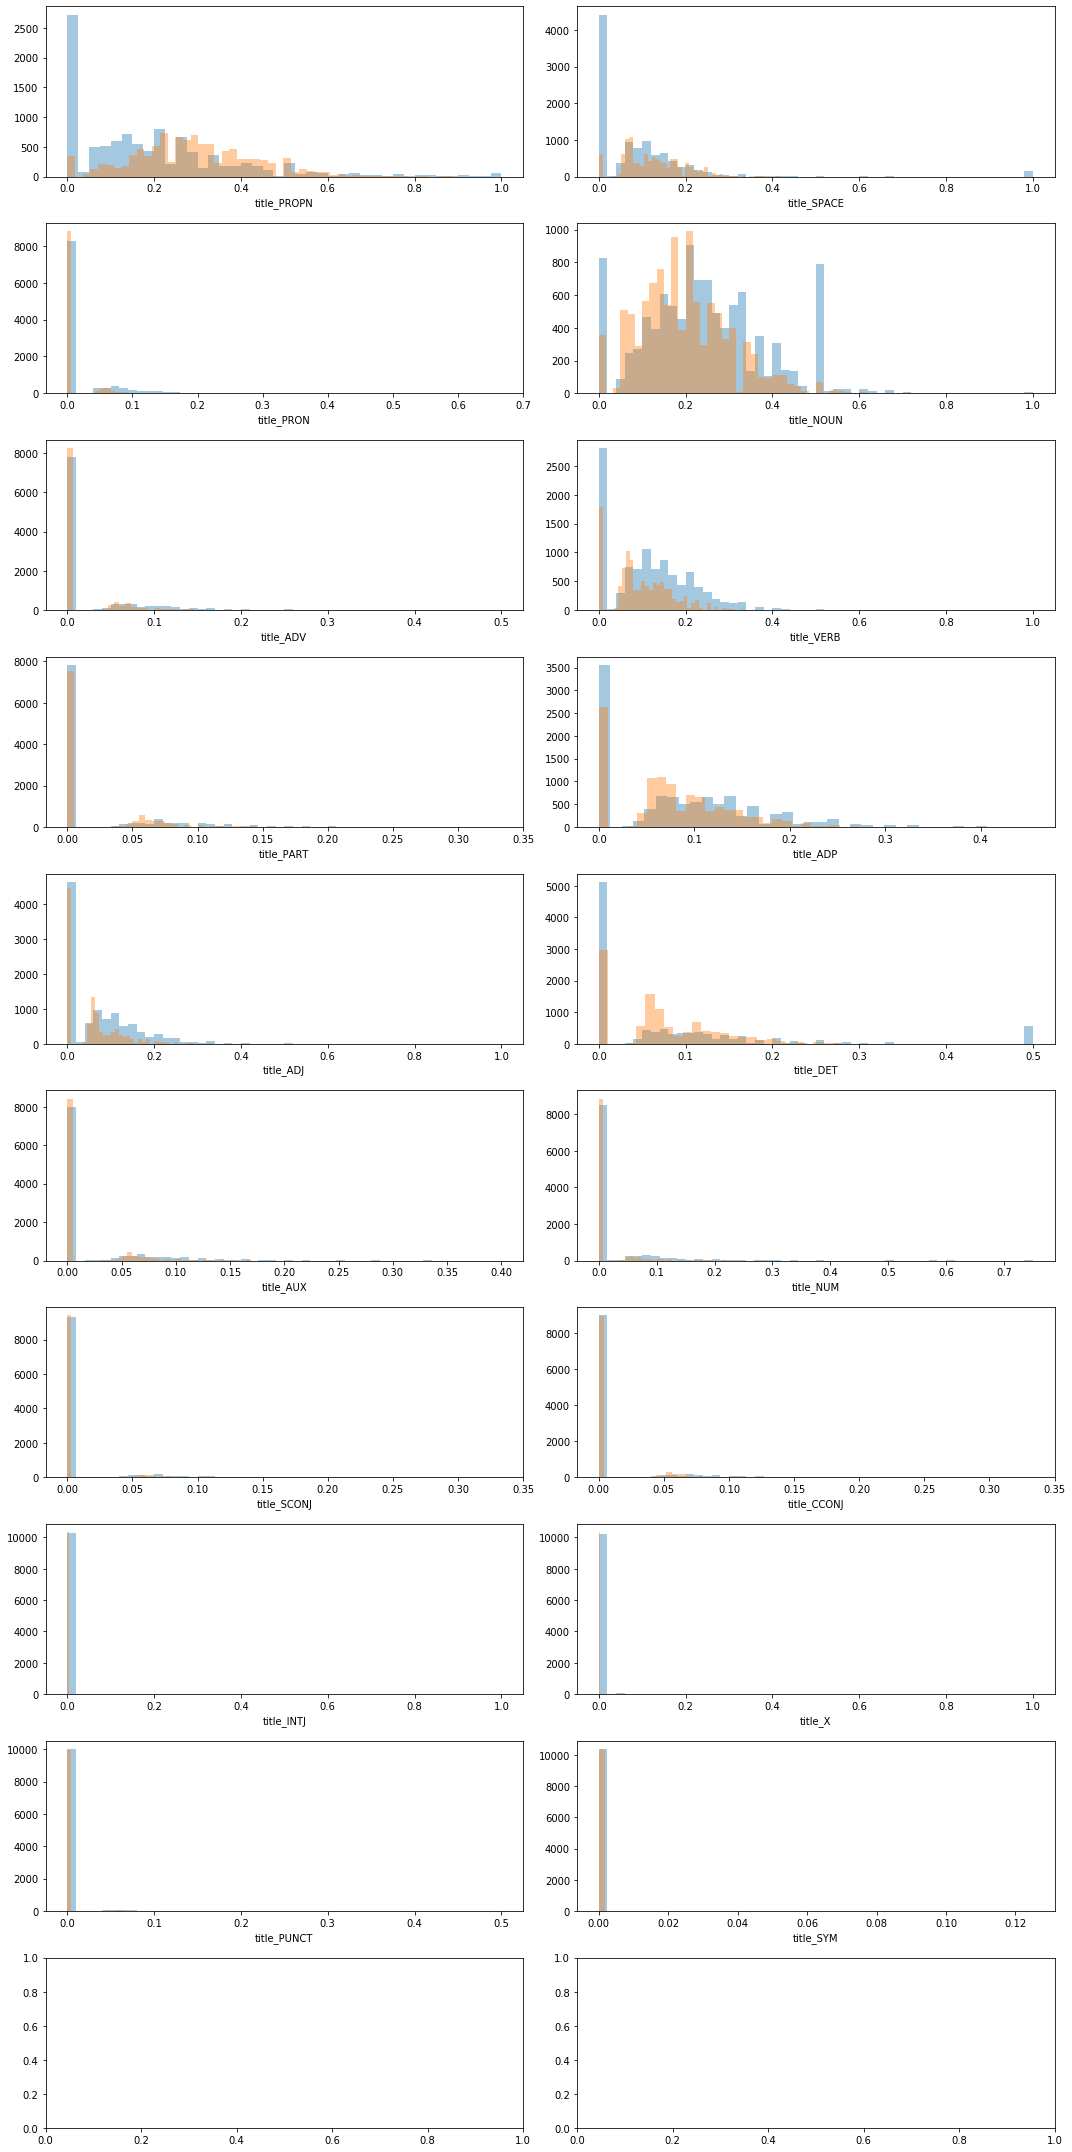

In [462]:
pos_plots(df_pos_norm_title, df['label'], 10, 2)

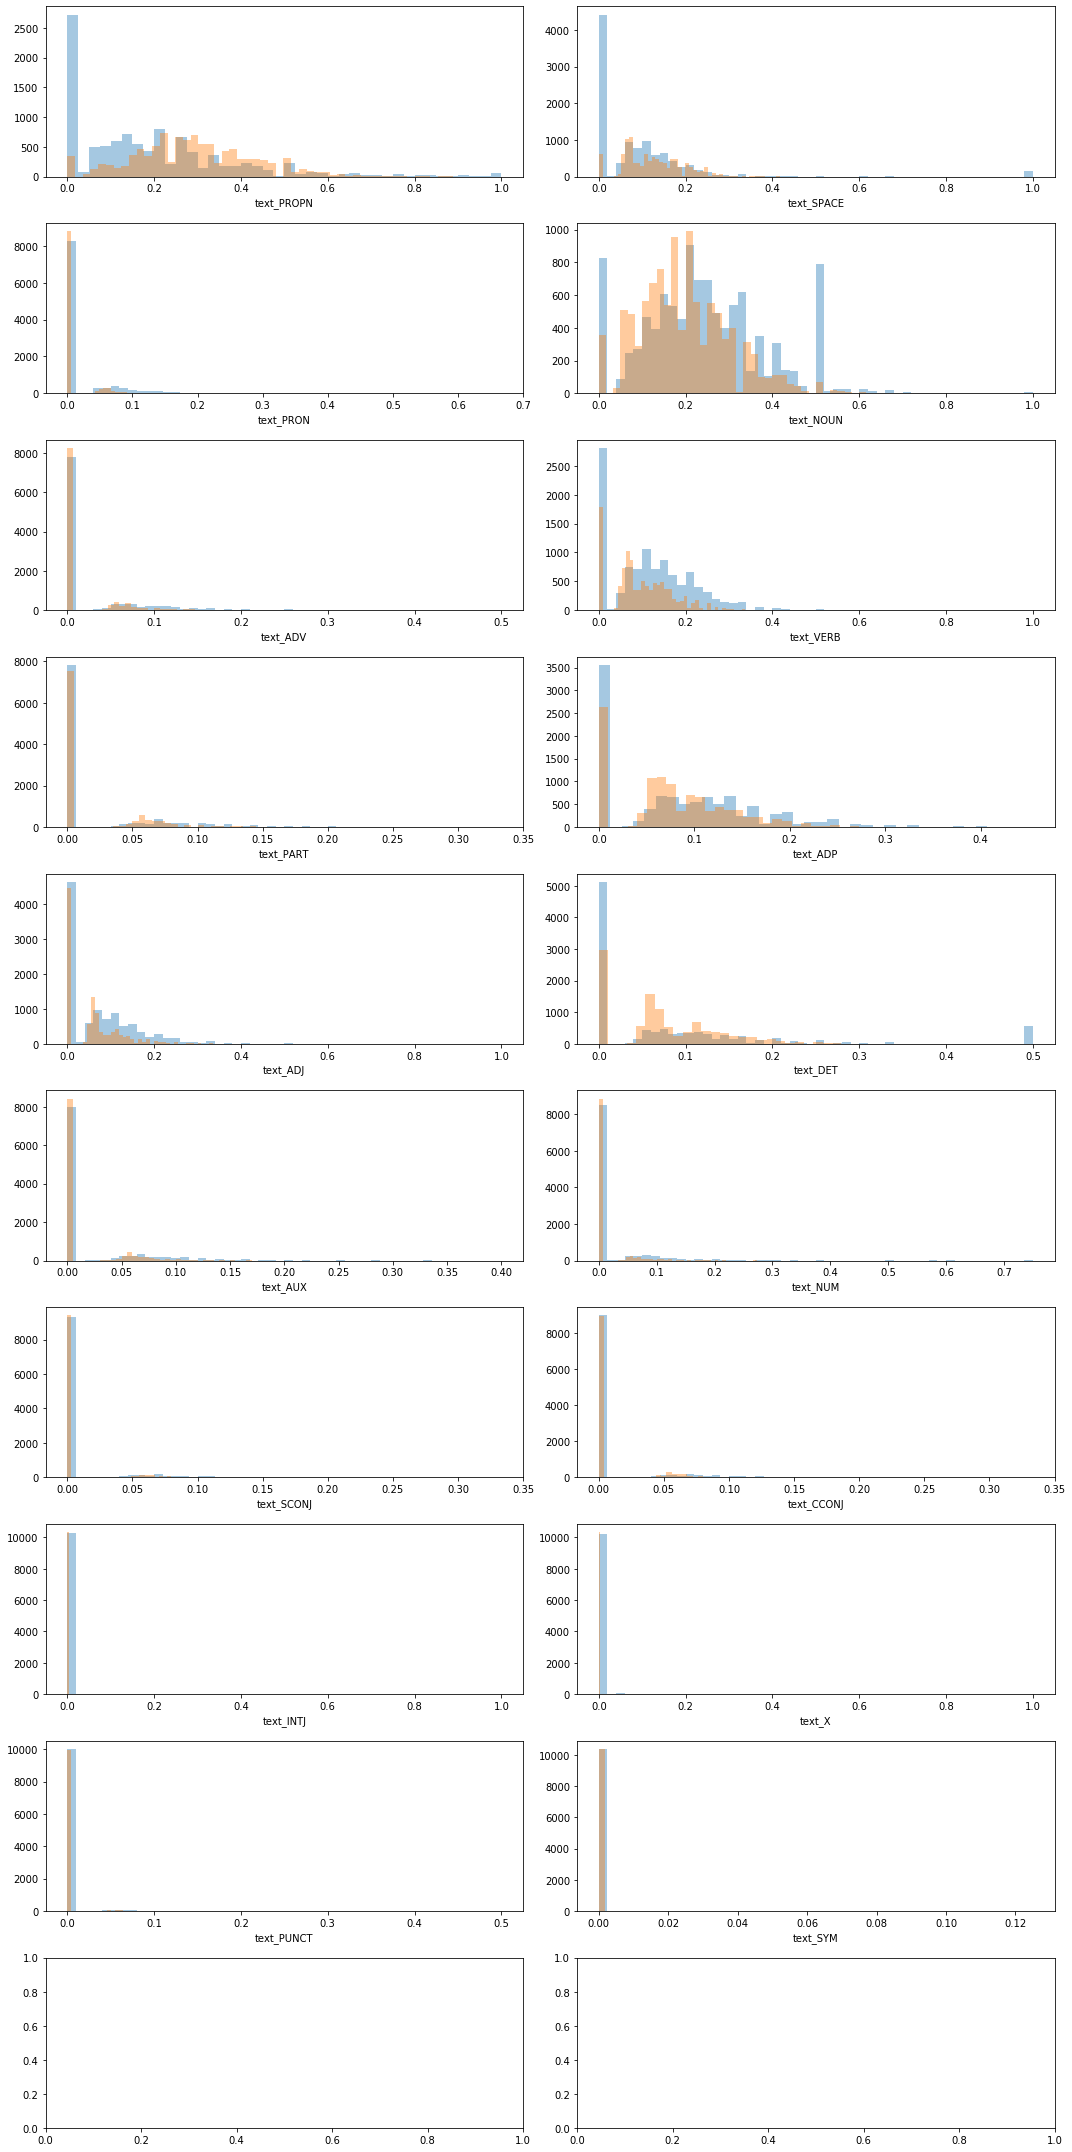

In [467]:
pos_plots(df_pos_norm_text, df['label'], 10, 2)

# Named Entity Statistics [Return](#ToC) <a id = 'NER'></a>

In [441]:
nlp = spacy.load('en_core_web_sm', disable = ['tagger', 'parser'])
nlp.pipe_names
rerun = True
if rerun:
    n_batch = 10
    ner_summary = []
    # Where texts is an iterator over your documents (unicode)
    for docs in nlp.pipe(df['text_clean'], batch_size=n_batch, n_threads=3):
        if len(docs) == 0:
            list_ner = [1, 1]
            ner_summary.append(dict(Counter(list_ner)))
        else:
            list_ner = [docs.ents[j].label_ for j in np.arange(len(docs.ents))]
            ner_summary.append(dict(Counter(list_ner)))
    filename = './param_store/NER_data_text'
    outfile = open(filename,'wb')
    pickle.dump(pos_summary, outfile)
    outfile.close()
else:
    filename = './param_store/NER_data_text'
    outfile = open(filename,'rb')
    pos_sumary = pickle.load(outfile)
    outfile.close()

In [442]:
df_orig = pd.DataFrame([list(ner_summary[0].values())], columns = list(ner_summary[0].keys()))
for idx in np.arange(1, len(ner_summary)):
    df_join = pd.DataFrame([list(ner_summary[idx].values())], columns = list(ner_summary[idx].keys()))
    df_orig = pd.concat([df_orig, df_join], ignore_index = True)
df_orig.fillna(0, inplace = True)
df_ner_norm_text = df_orig.div(df_orig.sum(axis=1), axis=0)
df_ner_norm_text.fillna(0, inplace = True)
df_ner_norm_text = df_ner_norm_text.add_prefix('text_')

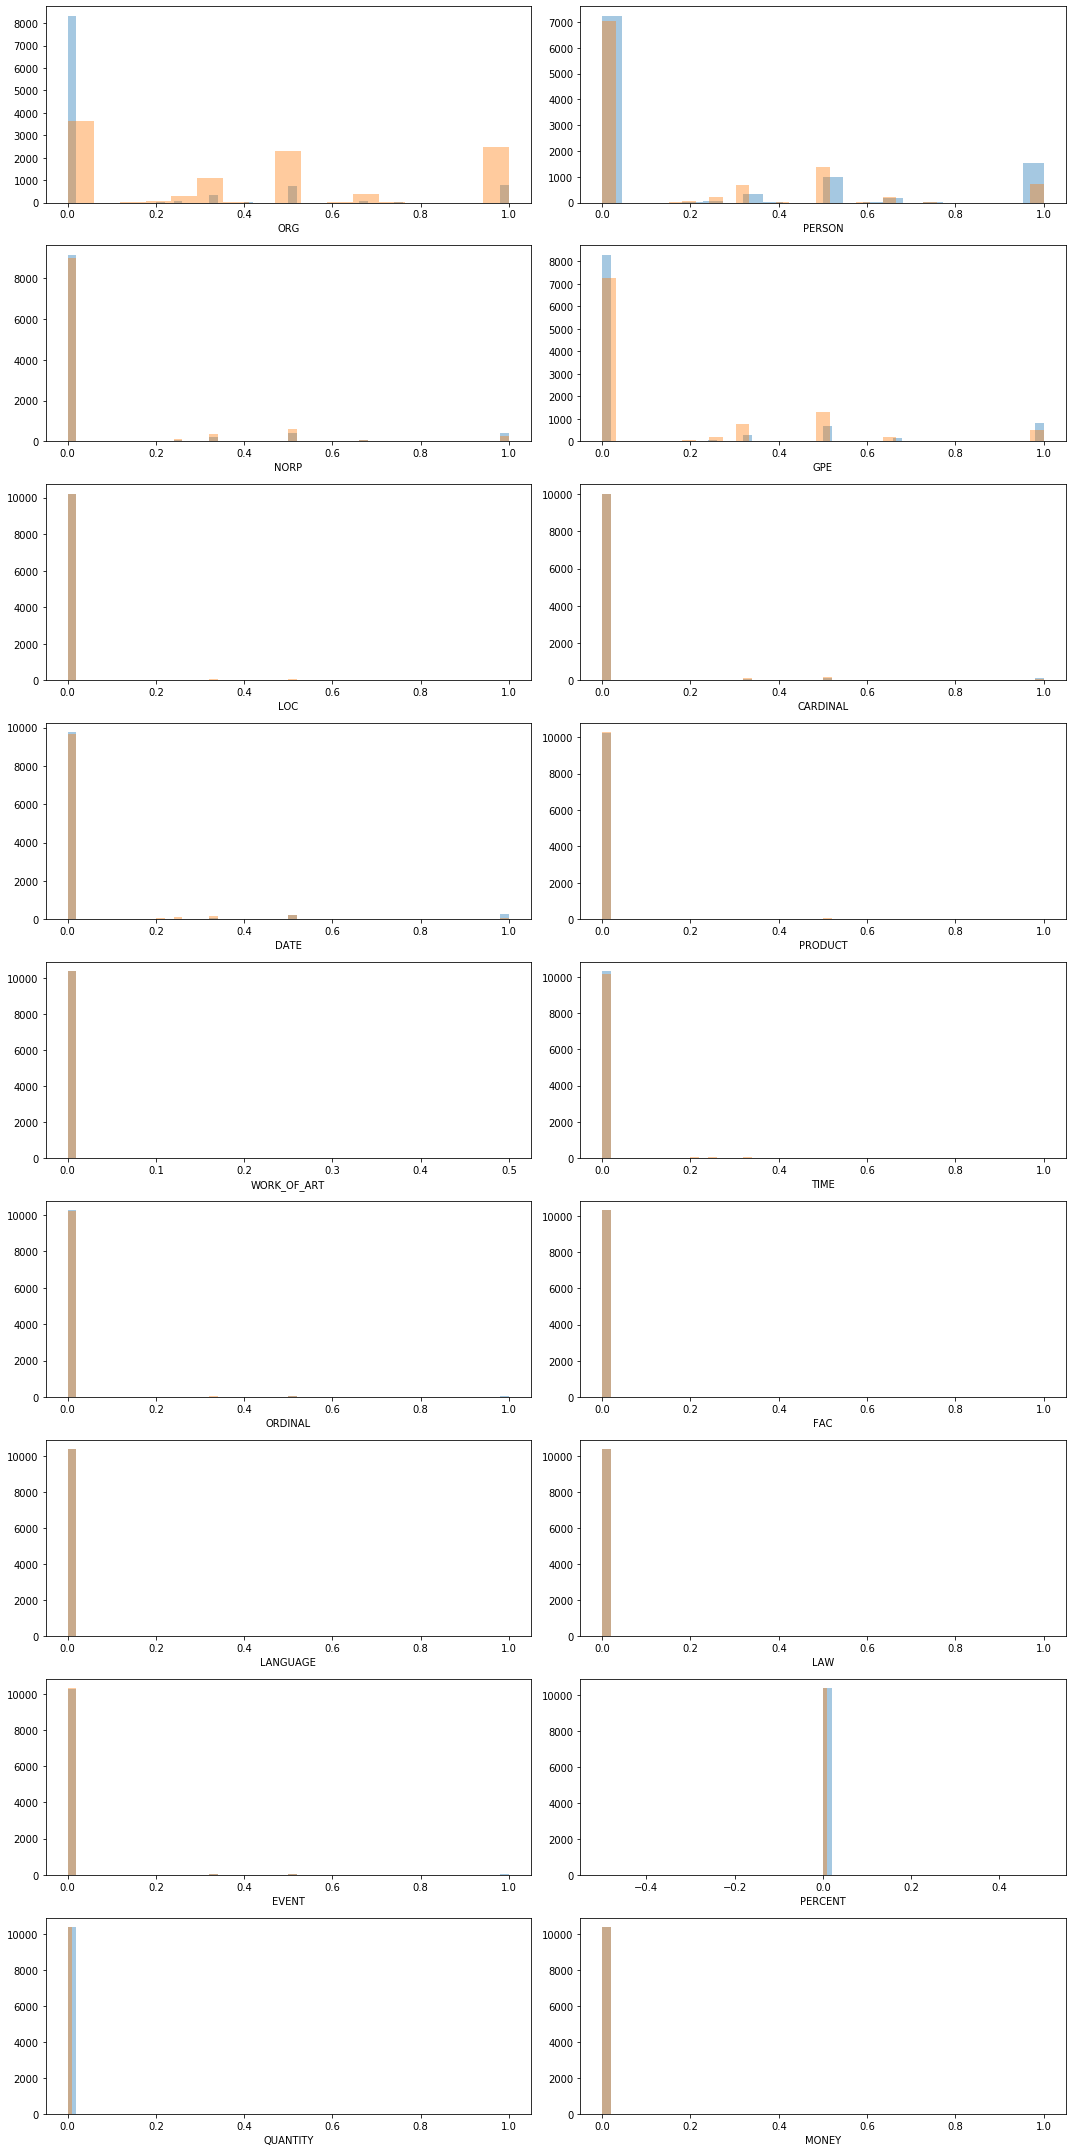

In [487]:
pos_plots(df_ner_norm_title, df['label'], 9, 2)

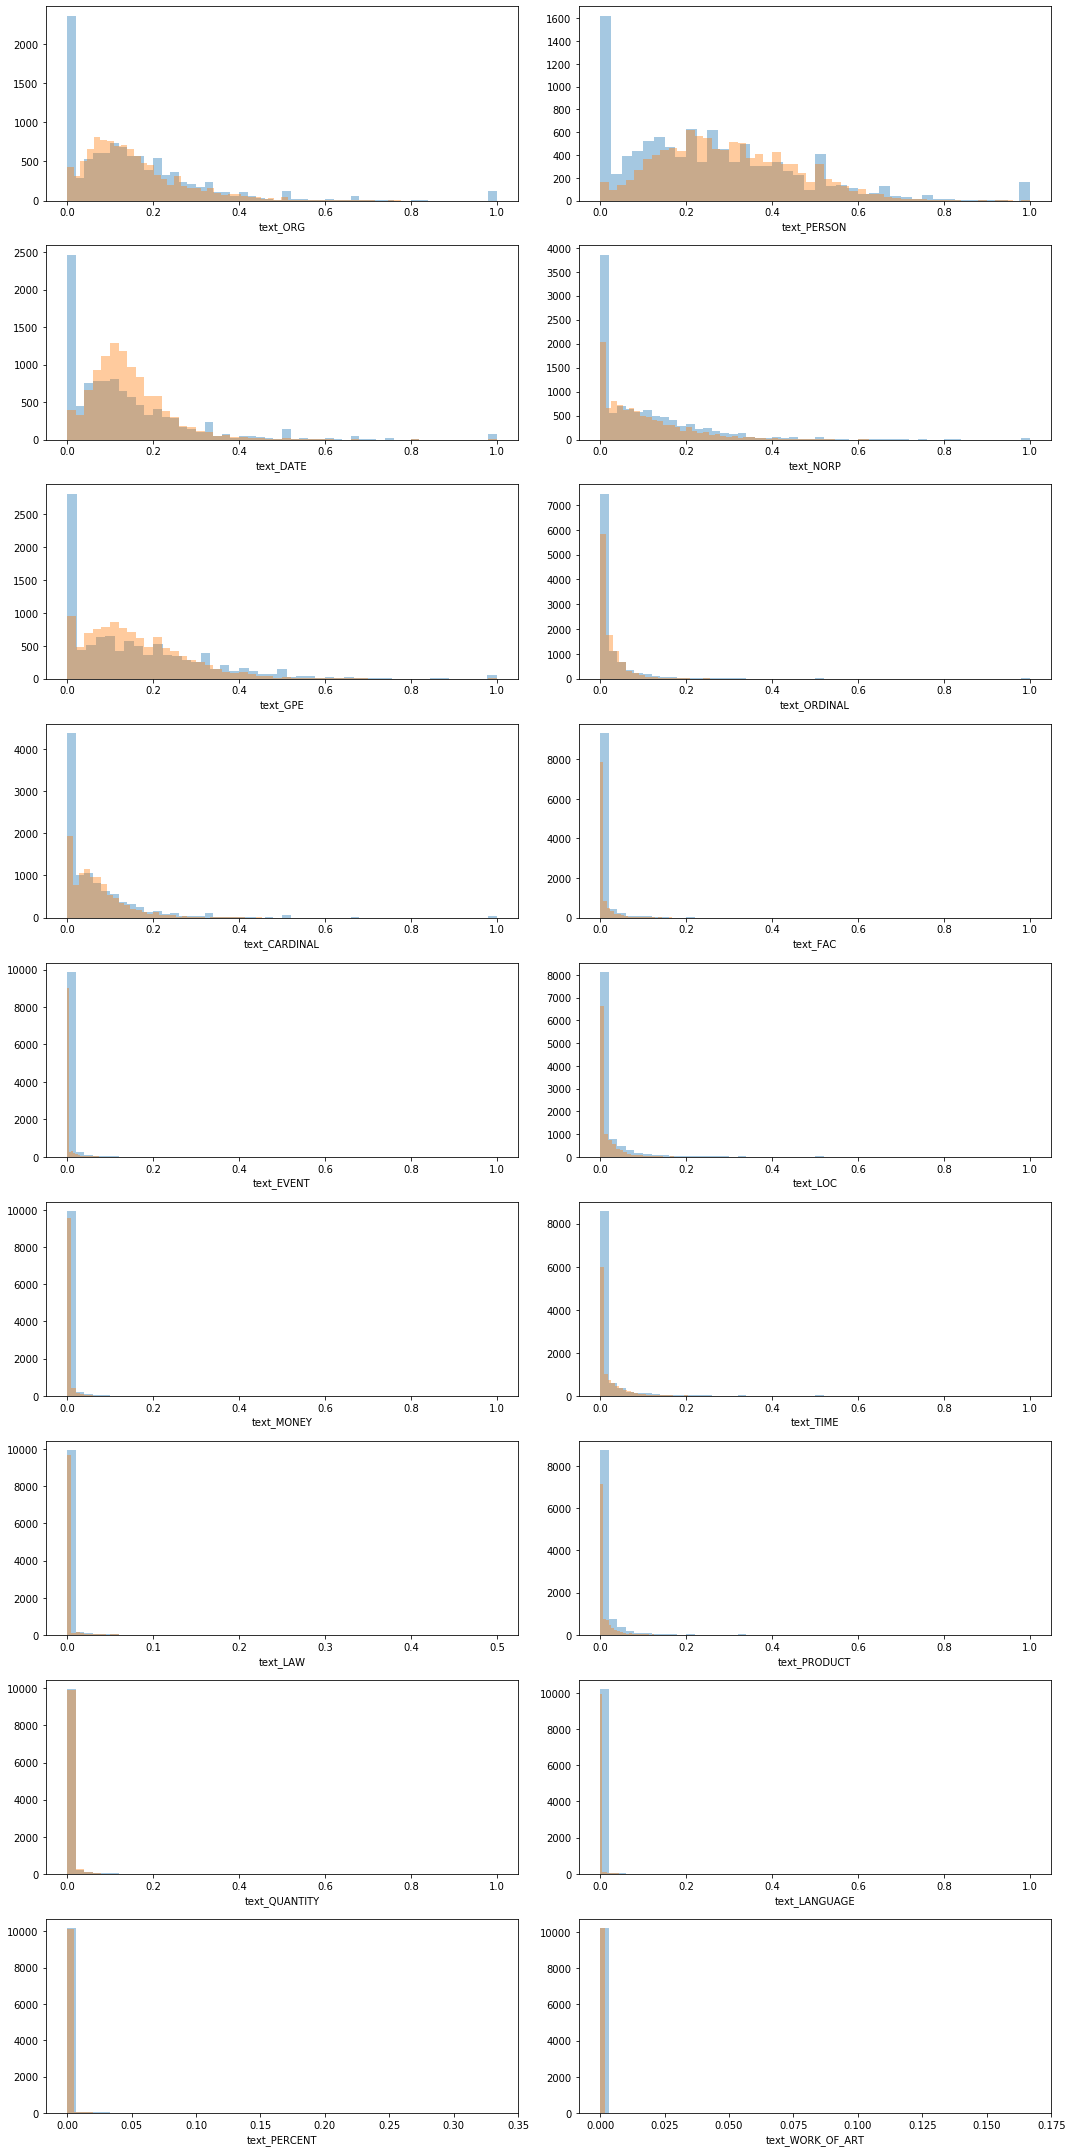

In [488]:
pos_plots(df_ner_norm_text, df['label'], 9, 2)

In [430]:
nlp = spacy.load('en_core_web_sm', disable = ['tagger', 'parser'])
nlp.pipe_names
rerun = True
if rerun:
    n_batch = 10
    ner_summary = []
    # Where texts is an iterator over your documents (unicode)
    for docs in nlp.pipe(df['title_clean'], batch_size=n_batch, n_threads=3):
        if len(docs) == 0:
            list_ner = [1, 1]
            ner_summary.append(dict(Counter(list_ner)))
        else:
            list_ner = [docs.ents[j].label_ for j in np.arange(len(docs.ents))]
            ner_summary.append(dict(Counter(list_ner)))
    filename = './param_store/NER_data_title'
    outfile = open(filename,'wb')
    pickle.dump(pos_summary, outfile)
    outfile.close()
else:
    filename = './param_store/NER_data_title'
    outfile = open(filename,'rb')
    pos_summary = pickle.load(outfile)
    outfile.close()

In [433]:
df_orig = pd.DataFrame([list(ner_summary[0].values())], columns = list(ner_summary[0].keys()))
for idx in np.arange(1, len(ner_summary)):
    df_join = pd.DataFrame([list(ner_summary[idx].values())], columns = list(ner_summary[idx].keys()))
    df_orig = pd.concat([df_orig, df_join], ignore_index = True)
df_orig.fillna(0, inplace = True)
df_ner_norm_title = df_orig.div(df_orig.sum(axis=1), axis=0)
df_ner_norm_title.fillna(0, inplace = True)
df_ner_norm_title = df_ner_norm_title.add_prefix('title_')

# Text Emotion statistics [Return](#ToC) <a id = 'Vader'></a>

The next analysis to consider is looking at how the is language is used to elicit emotions.

In [24]:
analyser = SentimentIntensityAnalyzer()
score = []
for sentence in df['title'].values:
    output = analyser.polarity_scores(sentence)
    output = list(output.values())[-1]
    score.append(output)
df['title_sentiment'] = score

In [280]:
analyser = SentimentIntensityAnalyzer()
score = []
for sentence in df['text'].values:
    output = analyser.polarity_scores(sentence)
    output = list(output.values())[-1]
    score.append(output)
df['text_sentiment'] = score

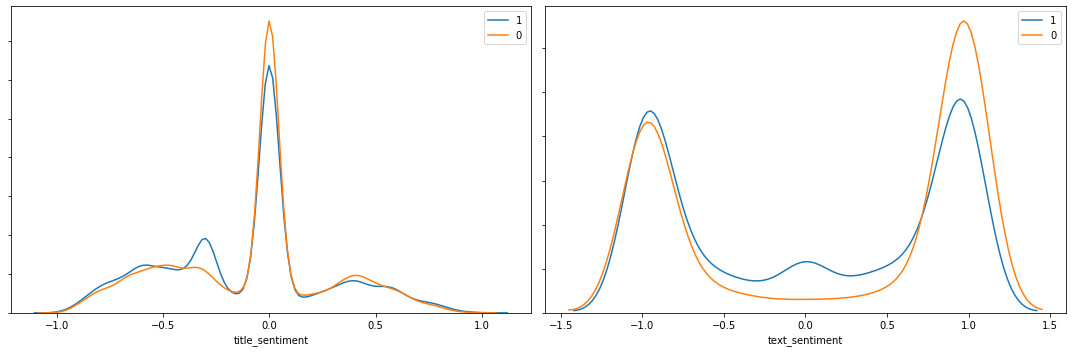

In [281]:
plot_multiple_kdes(df, ['title_sentiment', 'text_sentiment'], 2, 1)

# Text topic analysis [Return](#ToC) <a id = 'LDA'></a>

In [50]:
bow = CountVectorizer(max_df = 0.9, min_df = 0.1)
text_bow = bow.fit_transform(df['text_clean'])

lda = LatentDirichletAllocation()
res = lda.fit_transform(text_bow)
df_lda = pd.DataFrame(res, columns = ['_'.join(['lda_component',str(i)]) for i in np.arange(10)])

# Combine Features

In [468]:
features = pd.concat([df[['text_tot_chars', 
                          'text_tot_words', 
                          'text_tot_sentences',
                          'title_tot_chars', 
                          'title_tot_words',
                          'title_sentiment',
                          'text_sentiment']], 
                      tfidf_df, 
                      df_pos_norm_text, 
                      df_pos_norm_title,
                      df_ner_norm_text,
                      df_ner_norm_title,
                      df_lda,
                      df[['label']]], axis = 1)

In [489]:
features.to_csv('./data/fake_news_features.csv', index = False)